## HuggingFace 커스텀 프로젝트

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
dataset = load_dataset("nsmc")

dataset


Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [3]:
train_dataset = dataset['train']
test_dataset = dataset['test']
cols = train_dataset.column_names
cols

for i in range(5):
    for col in cols:
        print(col, ":", train_dataset[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




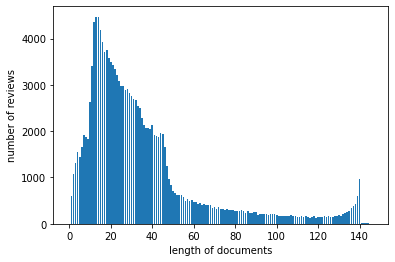

In [4]:
train_lengths = np.array(list(map(len, train_dataset['document'])))

lengths, counts = np.unique(train_lengths, return_counts=True)
plt.bar(x=lengths, height=counts)
plt.xlabel('length of documents')
plt.ylabel('number of reviews')
plt.show()

In [5]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [7]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        max_length = 80,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [8]:
train_dataset = train_dataset.map(transform, batched=True)
test_dataset = test_dataset.map(transform, batched=True)

train_dataset

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 150000
})

In [9]:
from transformers import Trainer, TrainingArguments

In [10]:
output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 4,   # 각 device 당 batch size, 최대 메모리 사이즈 문제 있음 
    per_device_eval_batch_size = 4,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [11]:
from datasets import load_metric

metric = load_metric('accuracy')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [12]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=test_dataset,       # test dataset
    compute_metrics=compute_metrics,
)

In [13]:
# fine-tuning
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 150000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 37500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408500,0.385436,0.902480


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoi

TrainOutput(global_step=37500, training_loss=0.41684268229166666, metrics={'train_runtime': 4382.3949, 'train_samples_per_second': 34.228, 'train_steps_per_second': 8.557, 'total_flos': 6166665360000000.0, 'train_loss': 0.41684268229166666, 'epoch': 1.0})

In [14]:
del model #delete model

In [16]:
def transform_unpadded(data):
    return tokenizer(
        data['document'],
        truncation=True,
        return_token_type_ids=False,
    )

# create unpadded dataset
train_dataset = dataset['train']
test_dataset = dataset['test']

train_dataset = train_dataset.map(transform_unpadded, batched=True)
test_dataset = test_dataset.map(transform_unpadded, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=4)

In [18]:
# load none fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

In [19]:
training_arguments = TrainingArguments(
    output_dir,
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True # group data by length
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator # add data collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [20]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 150000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Epoch,Training Loss,Validation Loss,Accuracy
1,0.258100,0.285034,0.902180


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoi

TrainOutput(global_step=18750, training_loss=0.31423892415364585, metrics={'train_runtime': 2427.6612, 'train_samples_per_second': 61.788, 'train_steps_per_second': 7.723, 'total_flos': 1902112041402240.0, 'train_loss': 0.31423892415364585, 'epoch': 1.0})